In [1]:
import numpy as np
from PIL import Image
from io import BytesIO

from face_tally.ml_logic.image_prediction import predict_bounding_boxes, crop_images
from rembg import remove
import os


/home/matias/.pyenv/versions/3.10.6/envs/facetally/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-06 14:05:54.358915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 14:05:54.359370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 14:05:54.549943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [2]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
images_path = os.path.join(parent_path, 'images')


backgrounds = {
    "happy": Image.open(os.path.join(images_path, 'backround_happy.jpg')),
    "angry": Image.open(os.path.join(images_path, 'backround_angry.jpg')),
    "sad": Image.open(os.path.join(images_path, 'backround_sad.jpg')),
    "neutral": Image.open(os.path.join(images_path, 'backround_neutral.jpg')),
    "fear": Image.open(os.path.join(images_path, 'backround_fear.jpg')),
    "disgust": Image.open(os.path.join(images_path, 'backround_disgust.jpg')),
    "surprise": Image.open(os.path.join(images_path, 'backround_surprise.jpg'))
}

genres = {
    "warrior": Image.open(os.path.join(images_path, 'warrior.png')),
    "princess": Image.open(os.path.join(images_path, 'princess.png'))
}


In [30]:
def get_images():
    current_path = os.getcwd()
    parent_path = os.path.dirname(current_path)
    images_path = os.path.join(parent_path, 'images')


    backgrounds = {
        "happy": Image.open(os.path.join(images_path, 'backround_happy.jpg')),
        "angry": Image.open(os.path.join(images_path, 'backround_angry.jpg')),
        "sad": Image.open(os.path.join(images_path, 'backround_sad.jpg')),
        "neutral": Image.open(os.path.join(images_path, 'backround_neutral.jpg')),
        "fear": Image.open(os.path.join(images_path, 'backround_fear.jpg')),
        "disgust": Image.open(os.path.join(images_path, 'backround_disgust.jpg')),
        "surprise": Image.open(os.path.join(images_path, 'backround_surprise.jpg'))
    }

    pics = {
        "Man": Image.open(os.path.join(images_path, 'warrior.png')),
        "Women": Image.open(os.path.join(images_path, 'princess.png')),
        "heart": Image.open(os.path.join(images_path, 'heart.png'))
    }

    return backgrounds, pics


In [31]:
backgrounds, pics = get_images()


In [7]:
from deepface import DeepFace


In [25]:
results = DeepFace.analyze(character_array, actions=["emotion", "age", "gender"])


Action: gender: 100%|██████████| 3/3 [00:25<00:00,  8.66s/it] 


'Man'

In [22]:
person = remove(character)


In [39]:
background = backgrounds[results[0]["dominant_emotion"]]
energy = pics[results[0]["dominant_gender"]]

background_resized = background.resize((600, 600))

new_width = 540
original_width, original_height = person.size
new_height = int((new_width / original_width) * original_height)
person_resized = person.resize((new_width, new_height))

energy = energy.resize((120,120))

text_img = Image.new('RGBA', (600,600), (0, 0, 0, 0))
text_img.paste(background_resized, (0,0))
text_img.paste(energy, (30,70), mask=energy)
text_img.paste(person_resized, (190, 80), mask=person_resized)


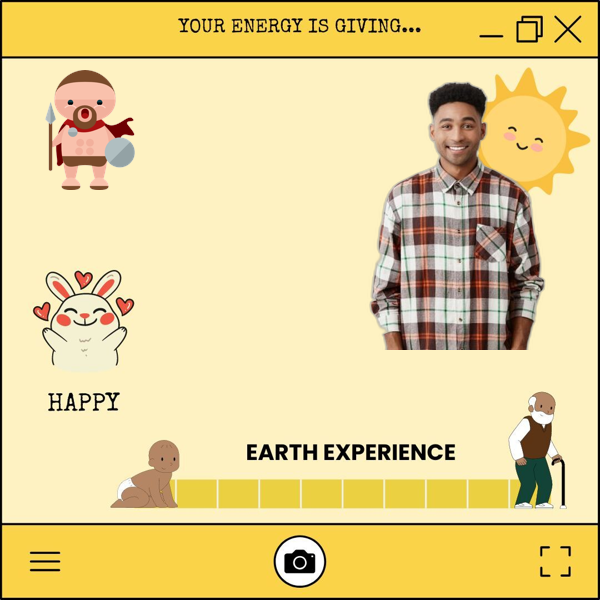

In [40]:
text_img


In [18]:
character = Image.open('trial_images/random_person_pic.jpg')
# output = remove(character)
character_array = np.array(character)


Action: age: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]    


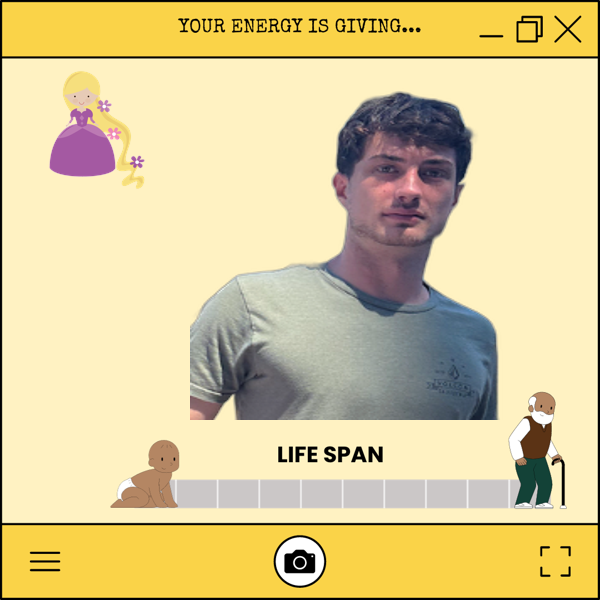

In [216]:
text_img
